In [ ]:
!wget "https://www.dropbox.com/scl/fo/hlujog78gi4zy8duy683h/AF-i2zym-HVnaEKJe4MhEv4?rlkey=tzdr361wsqcr1oda3vrfmypcf&dl=1" -O dropbox_folder.zip
!unzip dropbox_folder.zip -d extracted_data/

--2025-06-26 23:12:44--  https://www.dropbox.com/scl/fo/hlujog78gi4zy8duy683h/AF-i2zym-HVnaEKJe4MhEv4?rlkey=tzdr361wsqcr1oda3vrfmypcf&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce3276e1ff6c1acf5aeee2e9718.dl.dropboxusercontent.com/zip_download_get/CPwIhEGrgFz0PcGS8SbTdOrIVWseR1B7PgOaabXKl-Z95cnkhcg0dPbO1OwcAX4_flMlU5wdjJFjmiFOXr9AtimX1dV17nwM5hxpBgTnX86R6Q# [following]
--2025-06-26 23:12:45--  https://uce3276e1ff6c1acf5aeee2e9718.dl.dropboxusercontent.com/zip_download_get/CPwIhEGrgFz0PcGS8SbTdOrIVWseR1B7PgOaabXKl-Z95cnkhcg0dPbO1OwcAX4_flMlU5wdjJFjmiFOXr9AtimX1dV17nwM5hxpBgTnX86R6Q
Resolving uce3276e1ff6c1acf5aeee2e9718.dl.dropboxusercontent.com (uce3276e1ff6c1acf5aeee2e9718.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to uce3276e1ff6c1acf5aeee2e9718.dl.d

**“Other” refers to households where the head lives with individuals who are not a spouse or their own children. This category includes situations where the head lives with parents, grandparents, siblings, grandchildren, uncles, aunts, nephews, nieces, cousins, foster children, or unrelated adults such as roommates or boarders. These individuals reside in the head's household.**

##Question 1 :"WB16K1" , "If you buy a drink for 85 cents and pay with one dollar, how much change should you get back?"

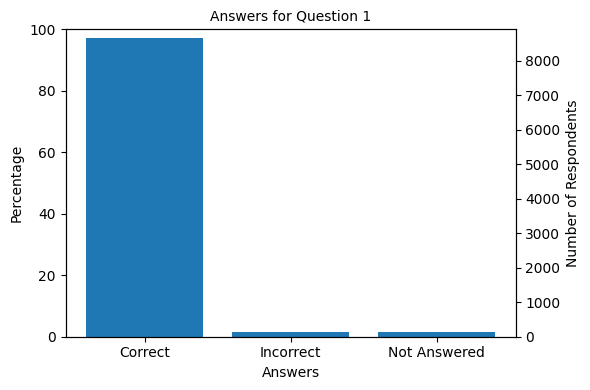

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K1"].notna()]
counts = answered["WB16K1"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 1", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**The vast majority of respondents answered Question 1 correctly, with very few providing incorrect answers or leaving it blank. This suggests the question was clearly understood and likely perceived as straightforward or easy.**

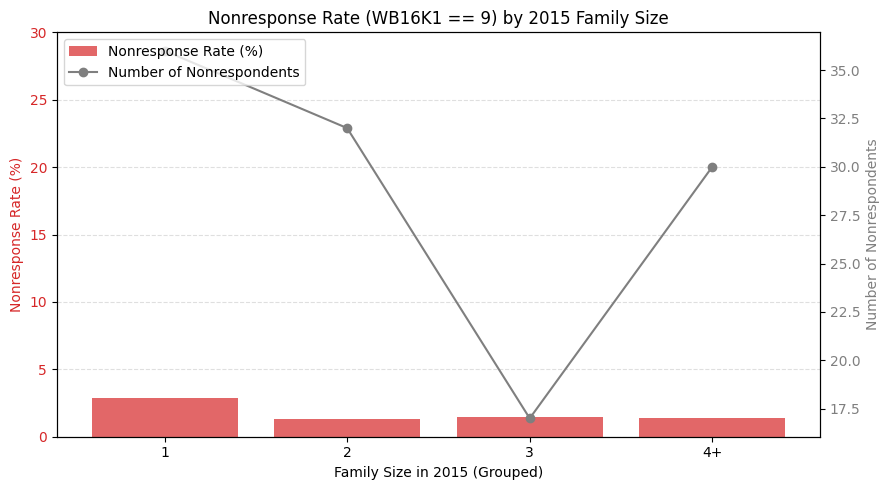

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K1"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate (WB16K1 == 9) by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates remain low across all family sizes, with only slight variation. This suggests that family size in 2015 had minimal impact on the likelihood of not responding to this question.**

/tmp/ipython-input-5-1144654676.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


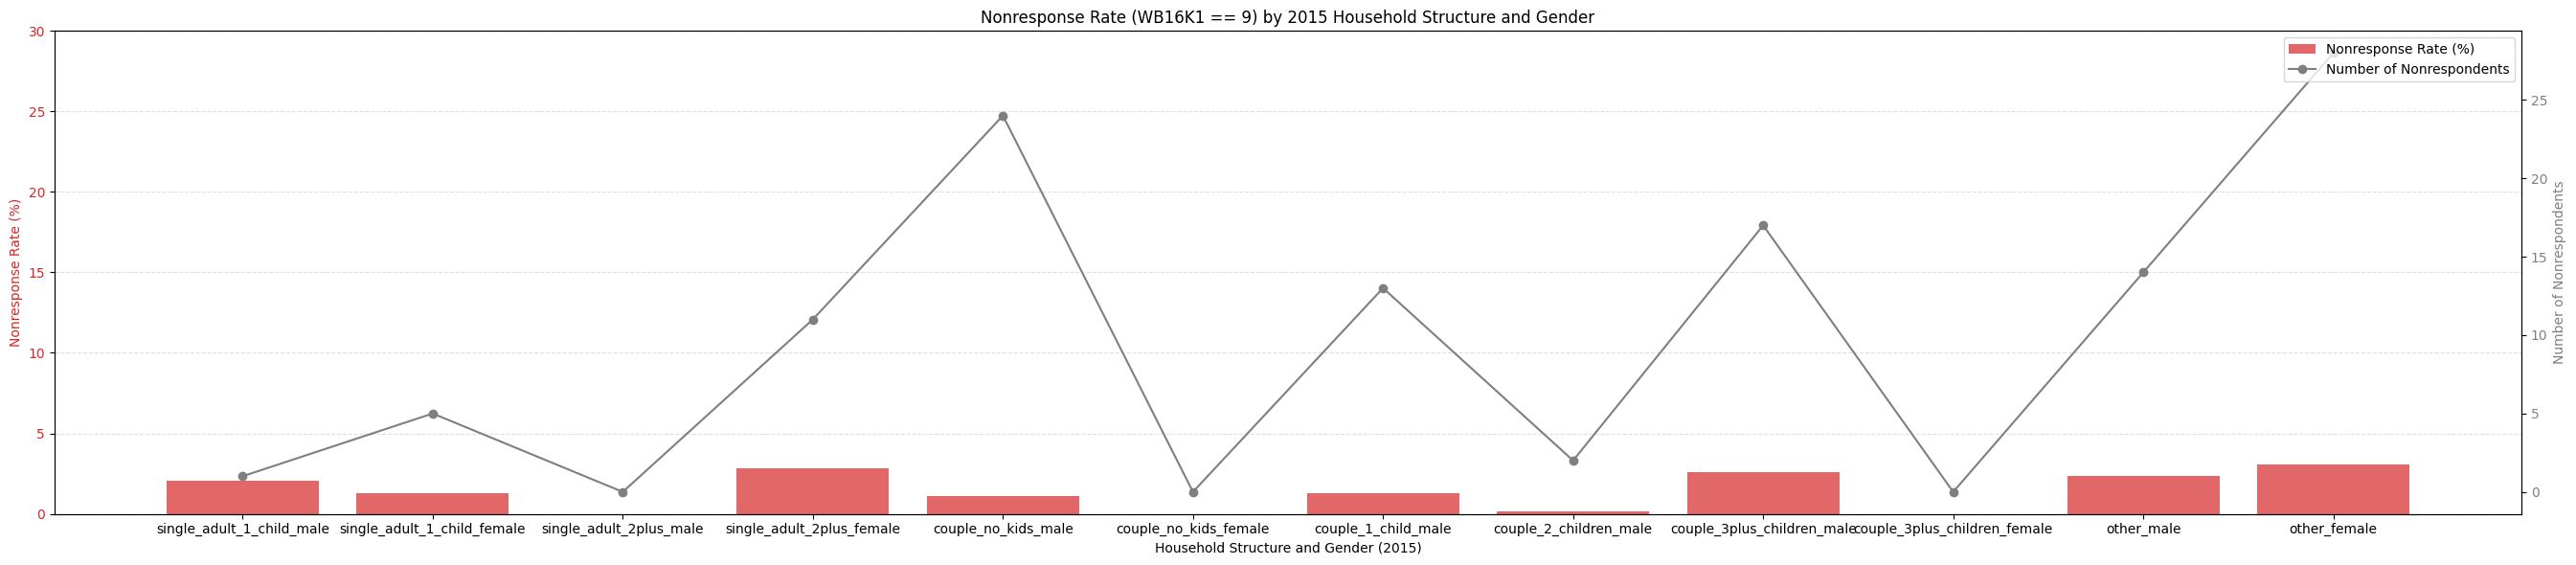

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K1"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K1"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 2 : "WB16K2" , A shop is having a half-price (50% off) sale. Before the sale, a sofa costs $300. How much will it cost on sale?

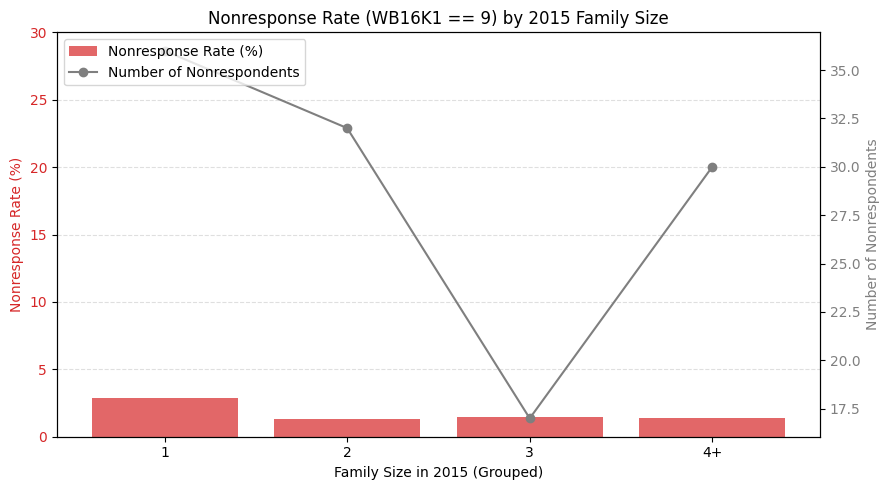

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K1"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**The figure shows that nonresponse rates are consistently low across different family sizes, with only minor fluctuations. This indicates that family size does not significantly influence the likelihood of nonresponse for this question**

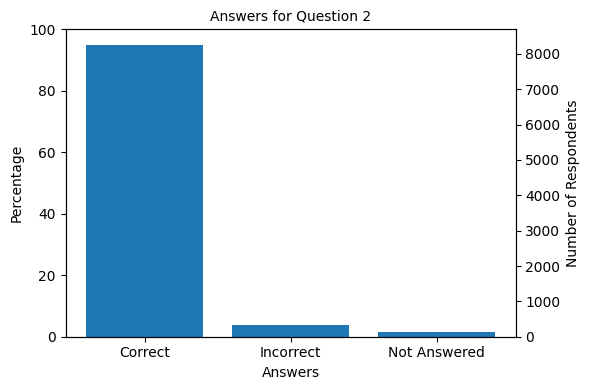

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K2"].notna()]
counts = answered["WB16K2"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 2", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Most respondents answered Question 2 correctly, with a small portion selecting incorrect answers or skipping the question. This suggests that the question was generally well-understood but slightly more challenging than Question 1.**

/tmp/ipython-input-8-1594842684.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


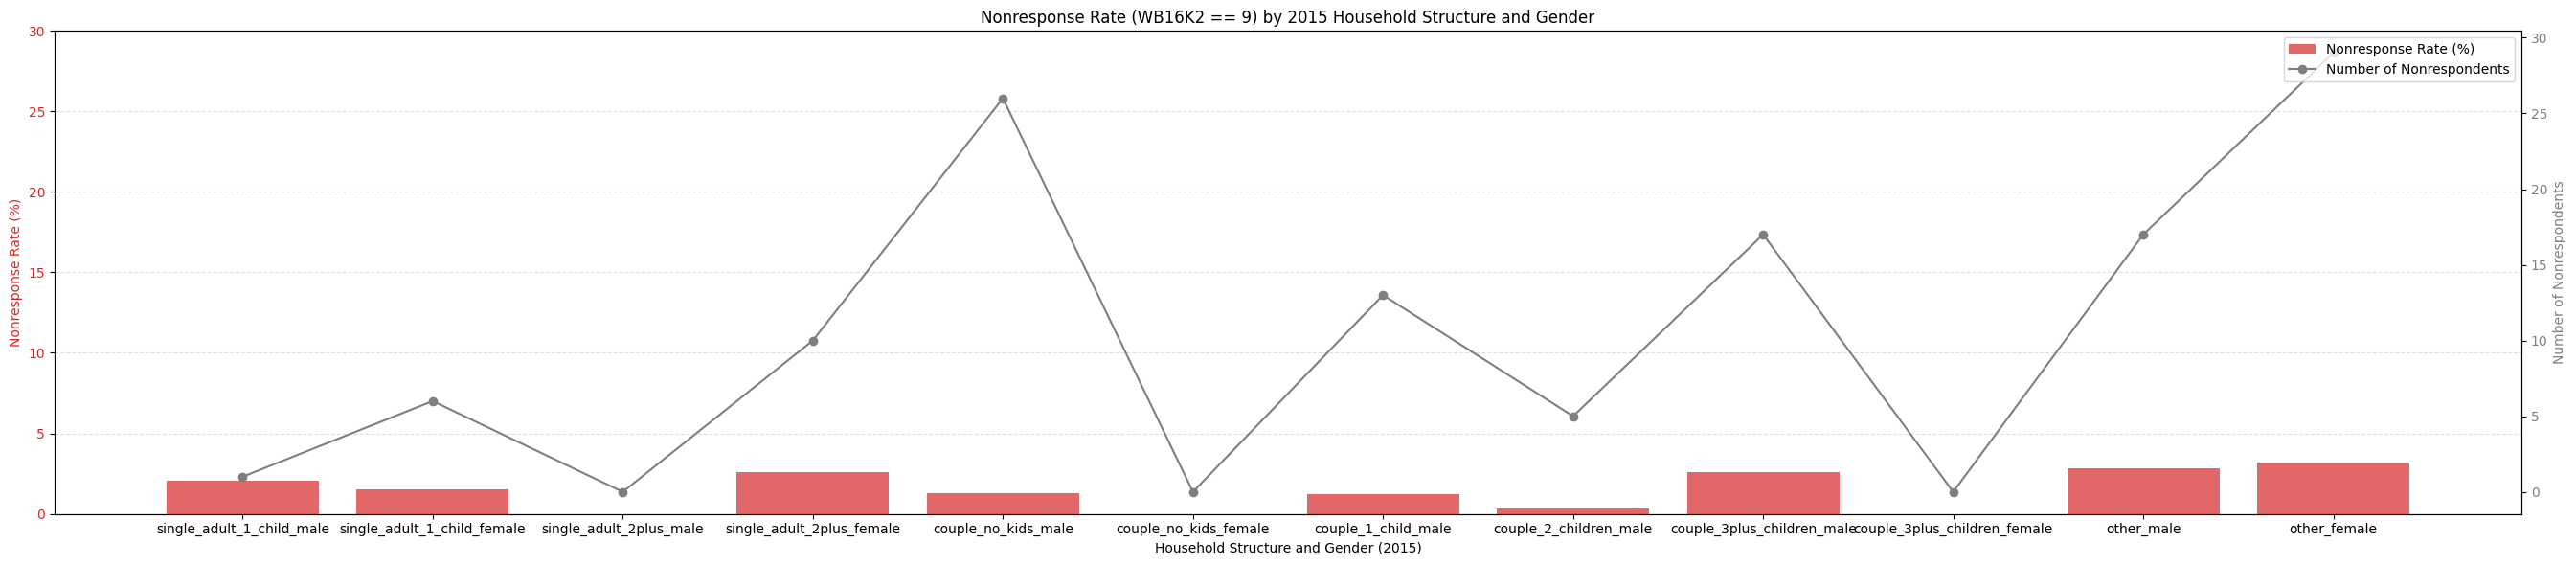

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K2"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K2"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 3 :"WB16K3", , If the chance of getting a disease is 10 percent, how many people out of 1,000 would be expected to get the disease?



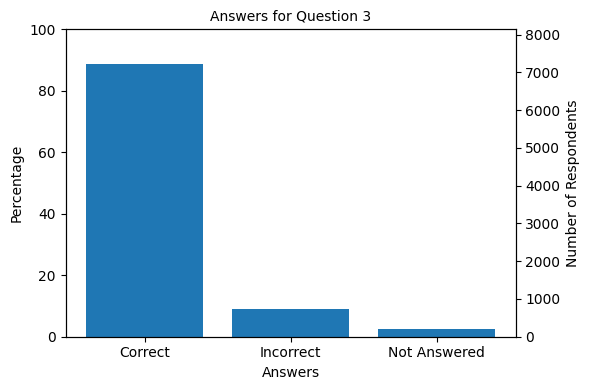

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K3"].notna()]
counts = answered["WB16K3"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 3", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 3 had a slightly lower correct response rate compared to earlier questions, with more incorrect answers and nonresponses. This suggests the question may have been more difficult or less clearly understood**

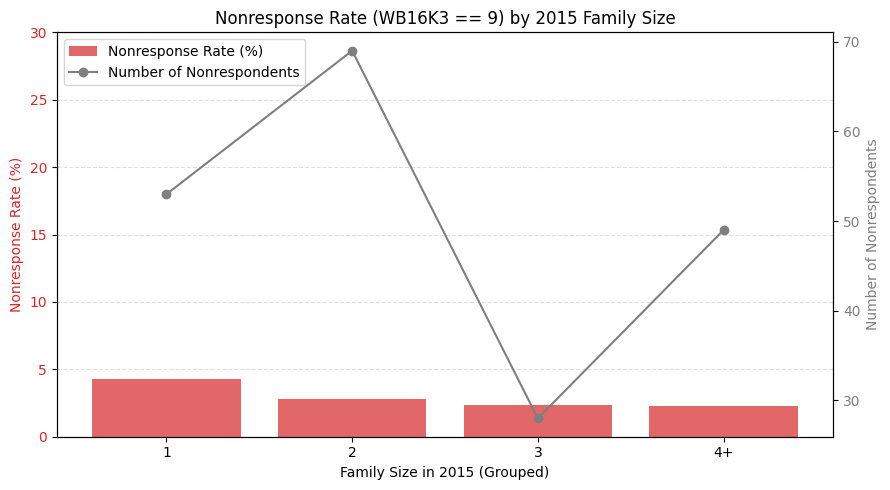

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K3"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question remain low across all family sizes, with only modest variation. This pattern suggests that family size in 2015 did not substantially influence the likelihood of skipping or refusing to answer**

/tmp/ipython-input-11-828547090.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


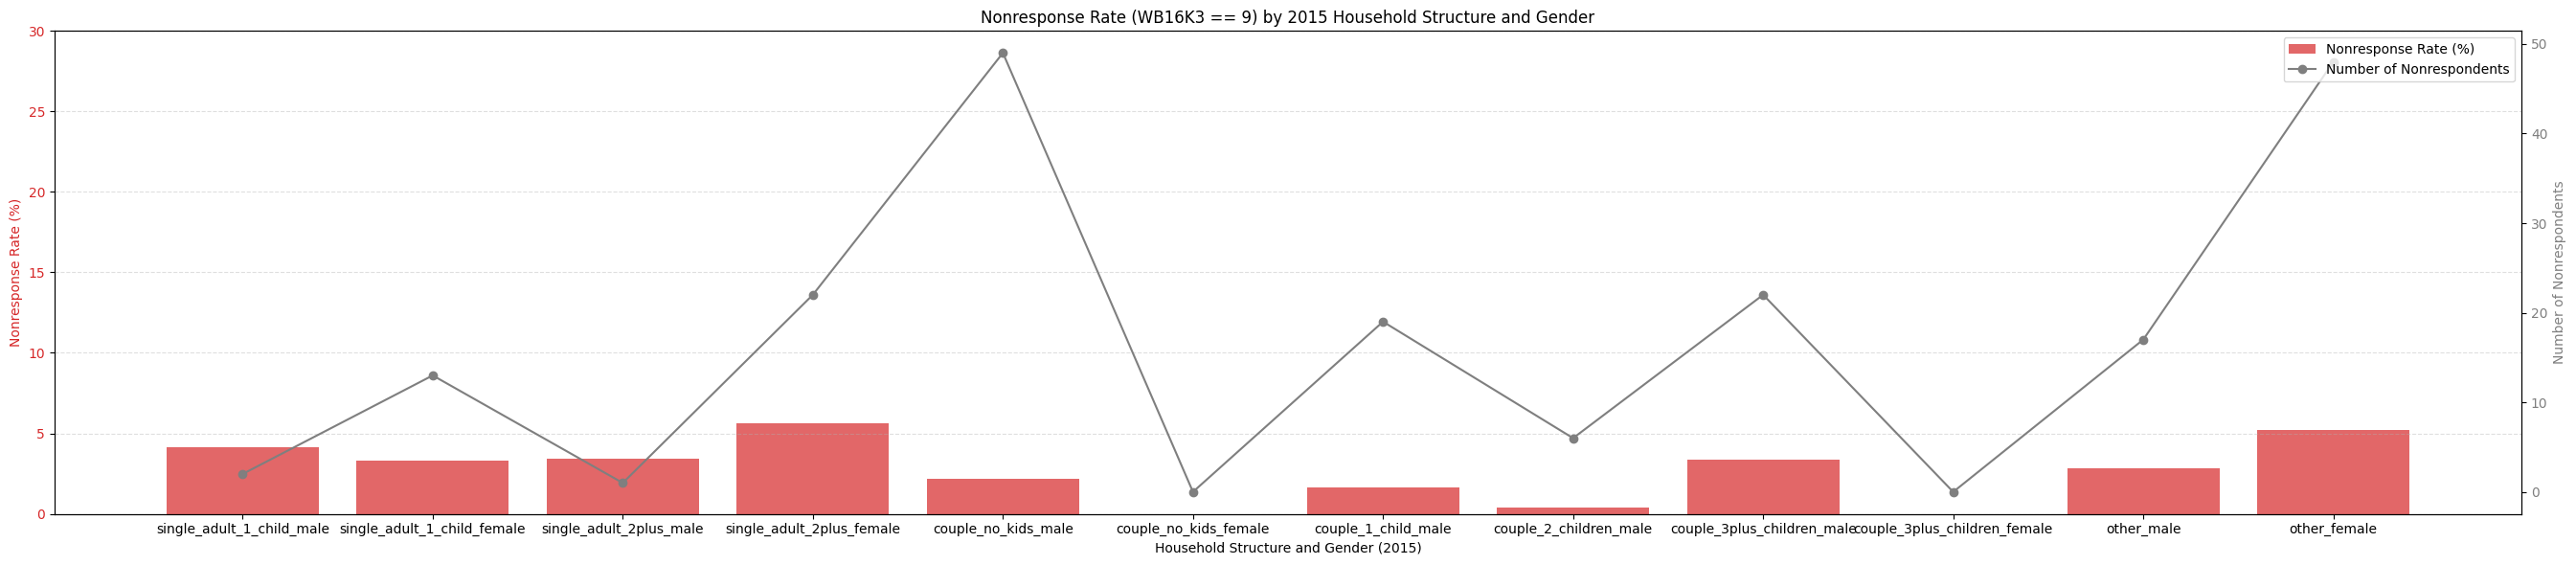

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K3"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K3"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 4 : "WB16K4", A used car dealer is selling a car for $6,000. This is two thirds of what it cost new. How much did the car cost new?



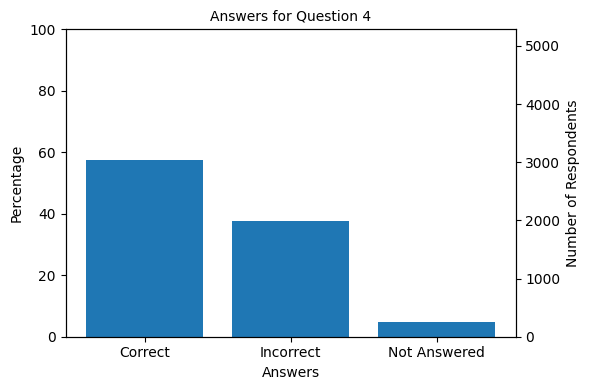

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K4"].notna()]
counts = answered["WB16K4"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 4", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 4 had a noticeably lower correct response rate compared to earlier questions, with a significant portion of incorrect answers. This suggests the question was more challenging or possibly less clearly understood by respondents**

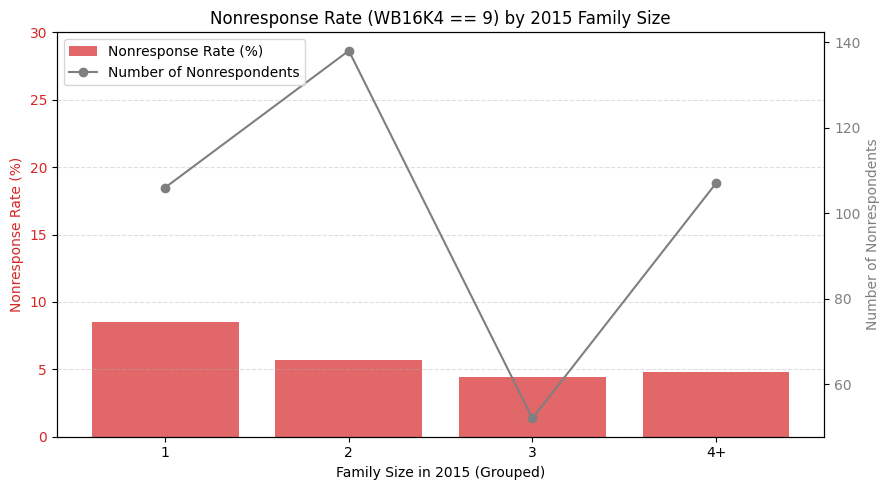

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K4"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question are low across all family sizes, with only slight variation. This suggests that family size did not significantly affect respondents' likelihood of answering this item**

/tmp/ipython-input-14-3809290866.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


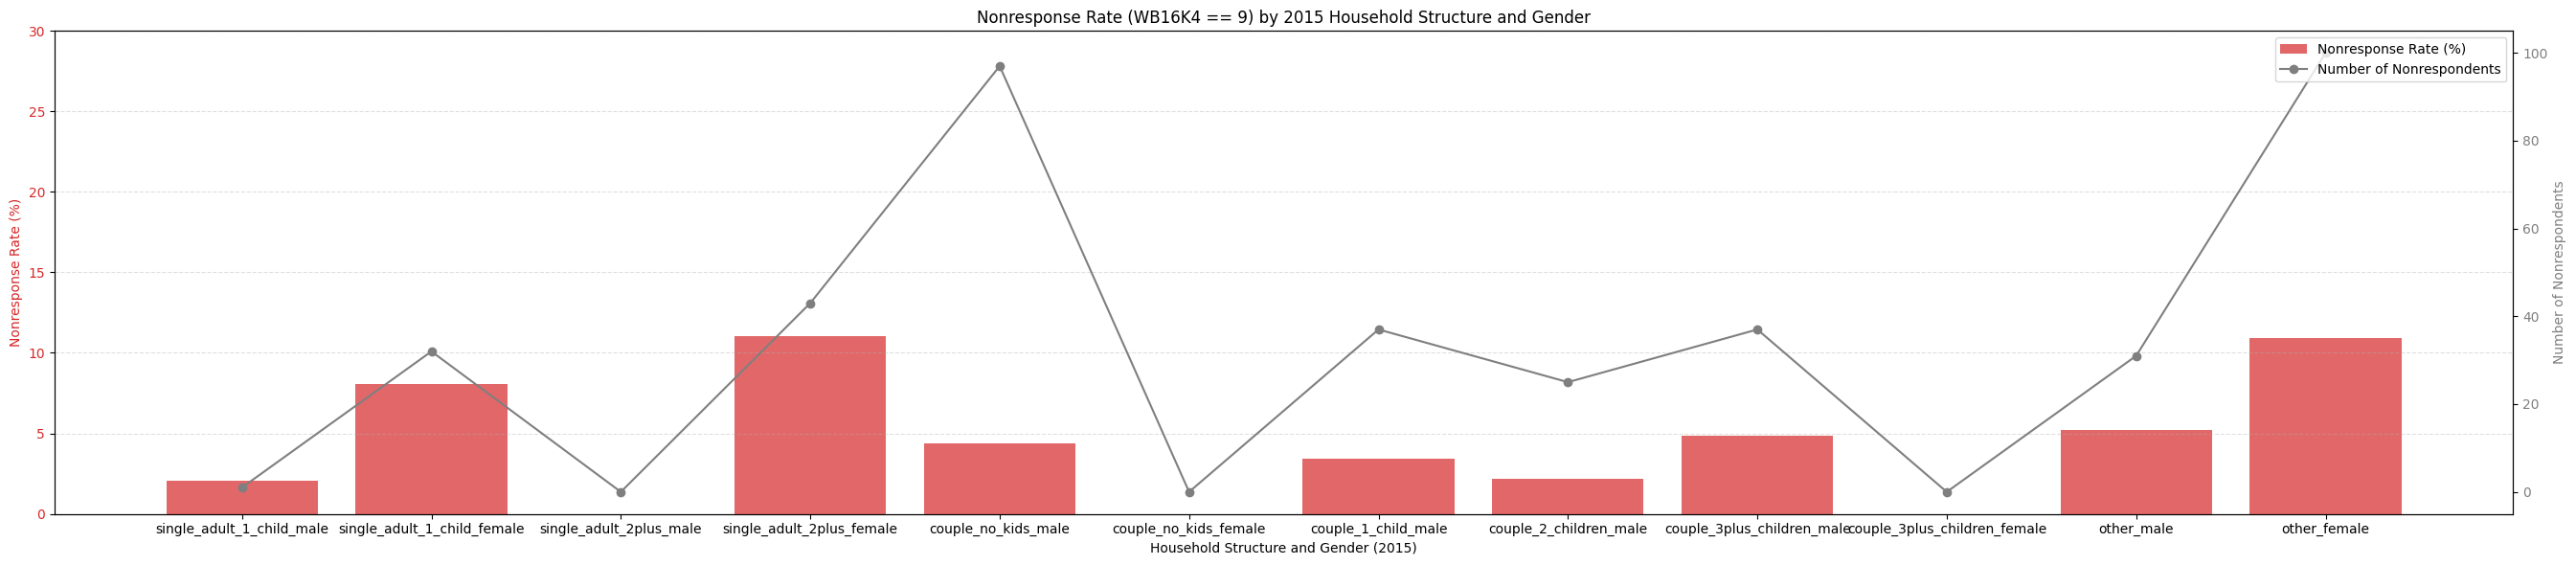

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K4"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K4"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 5 : "WB16K5", If 5 people all have the winning numbers in the lottery and the prize is $2 million, how much will each of them get?



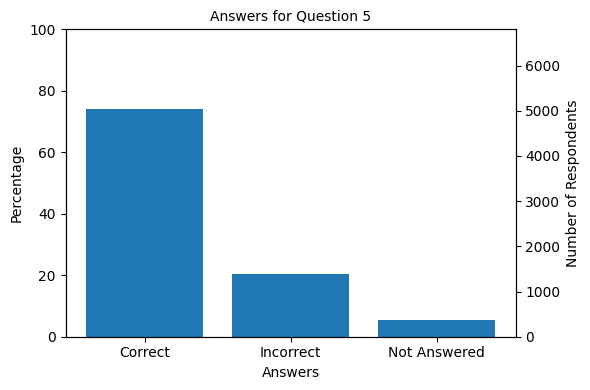

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K5"].notna()]
counts = answered["WB16K5"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 5", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**A majority of respondents answered Question 5 correctly, though the incorrect response rate is higher than in previous questions. This may indicate increased difficulty or a higher chance of confusion among participants**

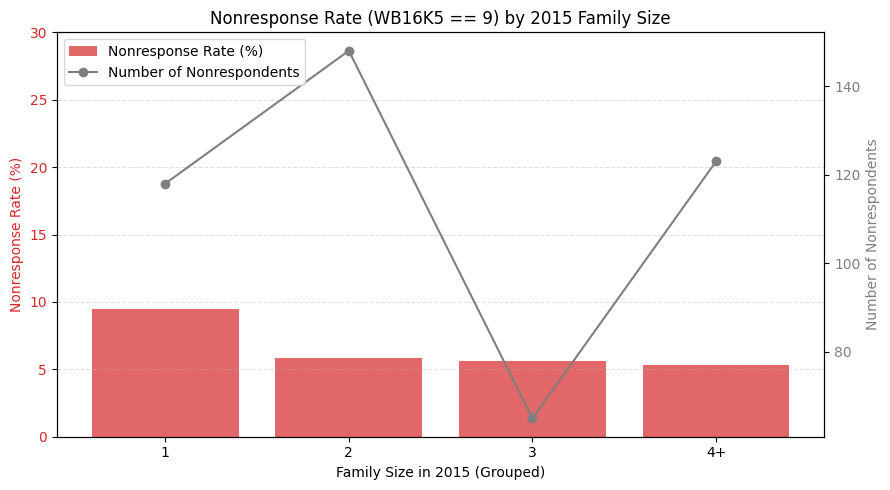

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K5"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate (WB16K5 == 9) by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question remain consistently low across all family sizes, with only small differences. This reinforces the pattern that family size does not play a major role in determining response behavior**

/tmp/ipython-input-17-1997108053.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


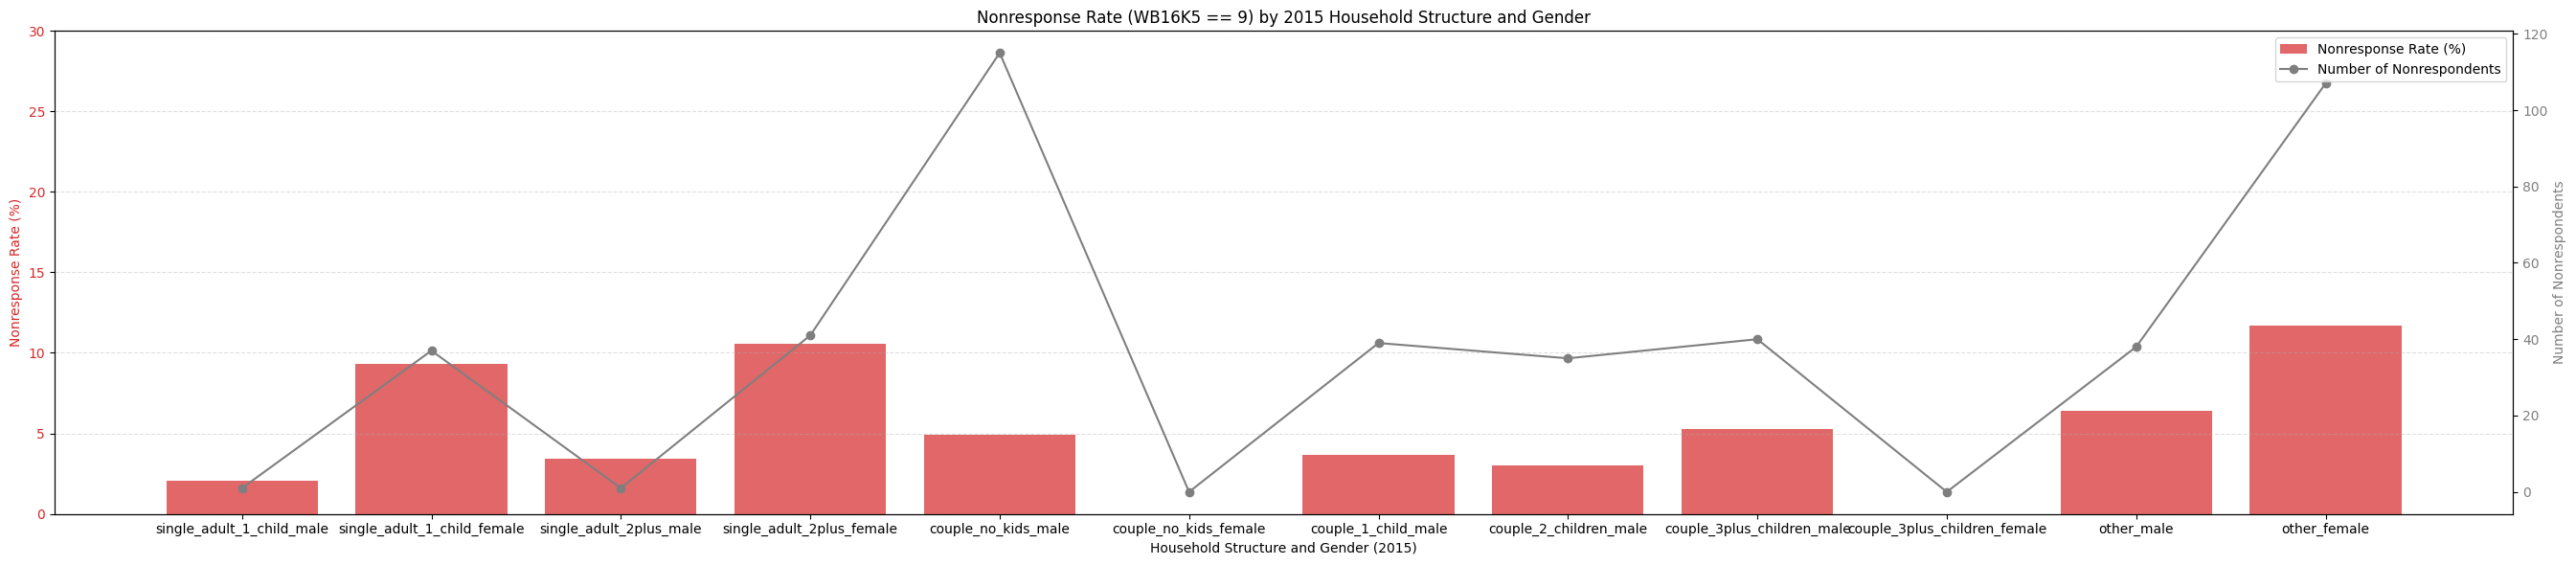

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K5"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K5"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 6 : "WB16K6" , Suppose you have $200 in a savings account. The account earns 10 percent interest each year. How much would you have in the account at the end of two years?



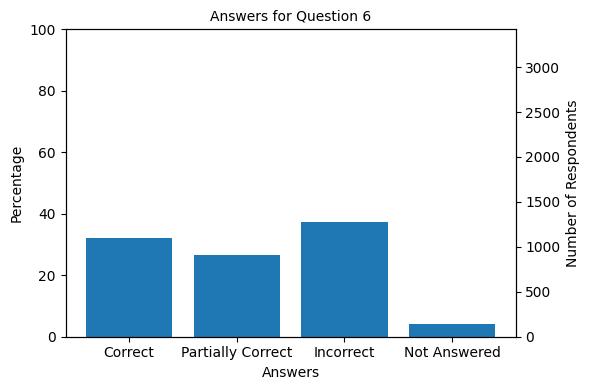

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K6"].notna()]
counts = answered["WB16K6"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 6", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 6 appears to be the most challenging so far, with a relatively low percentage of fully correct answers and a notable share of partially correct and incorrect responses. This suggests the question may have been complex or required multi-step reasoning.**

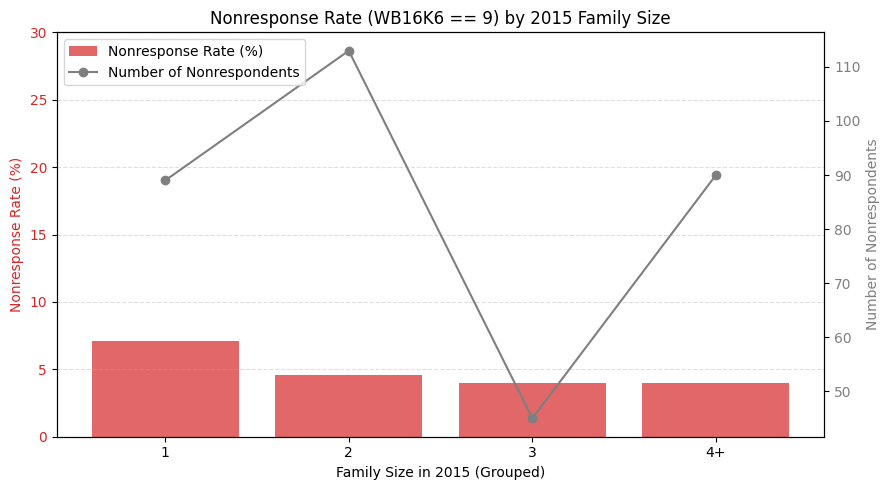

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K6"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question are low and relatively stable across all family sizes. This consistent pattern suggests that family size had little to no impact on respondents’ likelihood of skipping the question.**

/tmp/ipython-input-19-1097878331.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


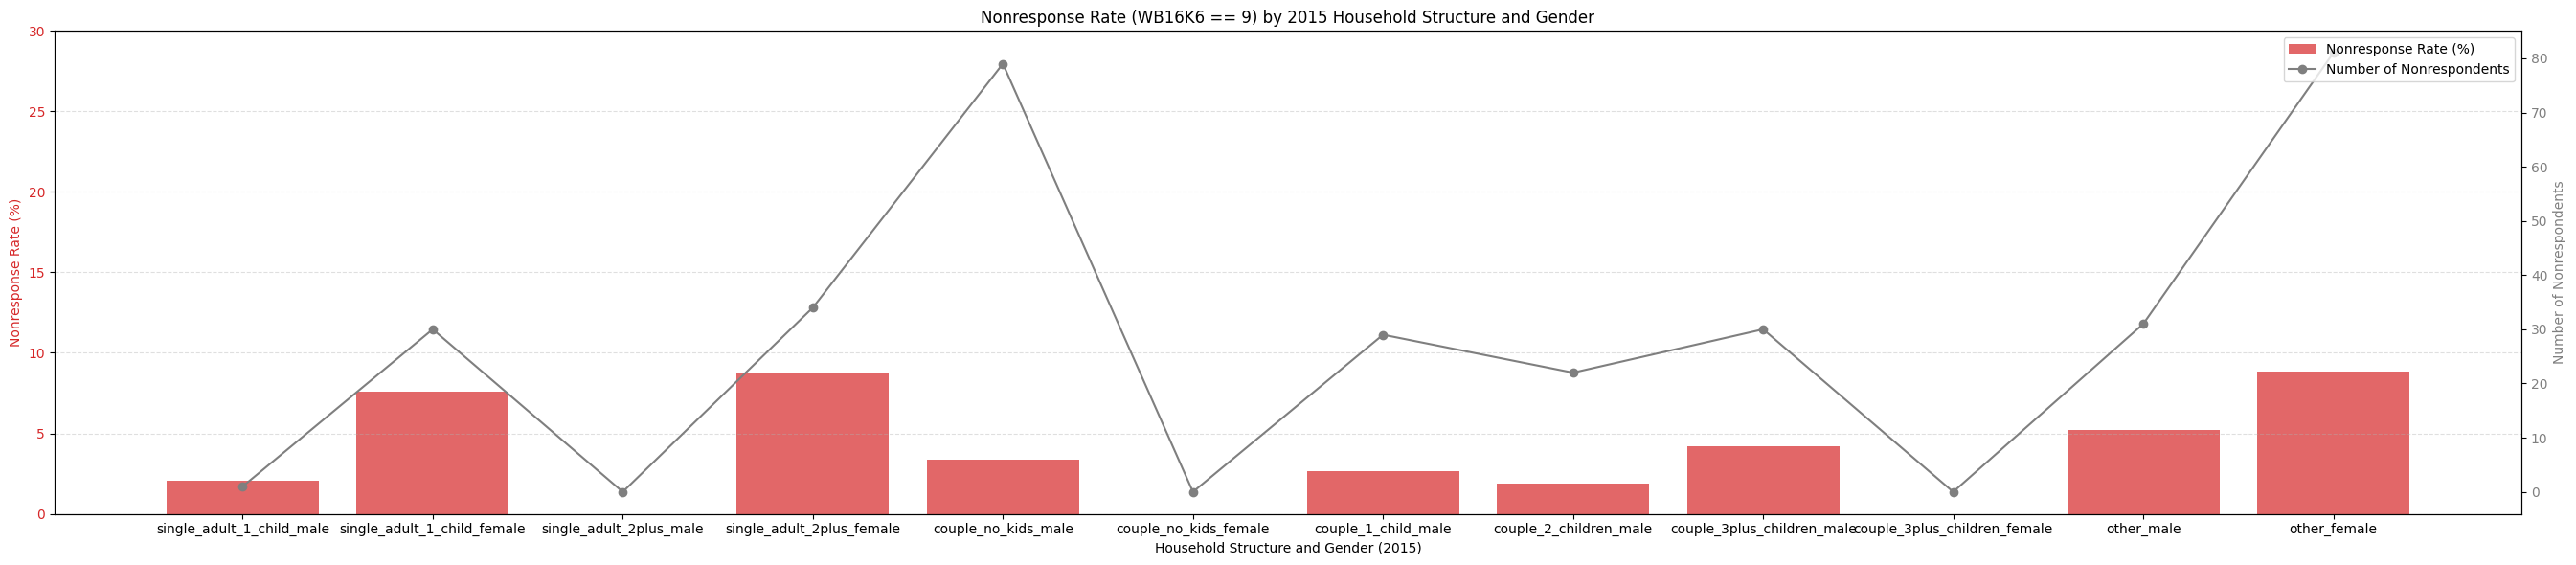

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K6"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K6"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


### overall the study showed that the nonresponse is minimal and the effect  of size of the family and structure on the response rate is minimal